In [1]:
# DSC291_Final_Project_FinalVersion(v4).ipynb
# -------------------------------------------------------------
# This notebook loads your CSV data, preprocesses it, constructs
# a bipartite graph, and then projects it to a contributor network.
# We then perform a fundamental analysis on the full graph (basis stats,
# centrality measures, and degree distribution) before applying any
# filtering for visualization.
#
# Further optimizations include:
#  - using approximate betweenness centrality by sampling (via k parameter)
#  - optional filtering (by degree or edge weight) for manageable visualization
#  - robustness simulation on the filtered subgraph
# -------------------------------------------------------------

import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import copy, random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#####################
# 1. DATA LOADING  #
#####################
csv_file = "top_100_stars_nodes_df.csv"
df_raw = pd.read_csv(csv_file)
print("Raw Data:")
print(df_raw.head())

# We assume the CSV is in wide format with a 'contributors' column.
# If 'Unnamed: 0' is present, we drop it. Then we fill NaNs with 0.
if 'contributors' in df_raw.columns:
    df_clean = df_raw.set_index('contributors')
    if 'Unnamed: 0' in df_clean.columns:
        df_clean.drop(columns=['Unnamed: 0'], inplace=True)
    df_clean = df_clean.fillna(0)
    print("Data assumed to be in pivoted wide format.")
else:
    # If your CSV was in long format, pivot it:
    df_clean = df_raw.pivot_table(index='contributor',
                                  columns='repo',
                                  values='contributions',
                                  fill_value=0)
    print("Pivoted data (long -> wide).")

print(df_clean.head())

# If the index isn't unique, group duplicates (sum contributions).
if not df_clean.index.is_unique:
    df_clean = df_clean.groupby(df_clean.index).sum()

print("Is the index unique now?", df_clean.index.is_unique)
print(df_clean.head())

Raw Data:
   Unnamed: 0     contributors  freeCodeCamp  free-programming-books  awesome  \
0           0        camperbot        1536.0                     NaN      NaN   
1           1      raisedadead        1487.0                     NaN      NaN   
2           2  ojeytonwilliams        1303.0                     NaN      NaN   
3           3    renovate[bot]        1262.0                     NaN      NaN   
4           4            sahat        1261.0                     NaN      NaN   

   build-your-own-x  public-apis  coding-interview-university  \
0               NaN          NaN                          NaN   
1               NaN          NaN                          NaN   
2               NaN          NaN                          NaN   
3               NaN          NaN                          NaN   
4               NaN          NaN                          NaN   

   developer-roadmap  system-design-primer  ...  django  app-ideas  bitcoin  \
0                NaN             

Bipartite graph created:
  #Contributor nodes: 27291
  #Repo nodes: 100
  #Edges in bipartite graph: 29715
Contributor collaboration network:
  Nodes: 27354, Edges: 5402107
Extra nodes in projected network: 63
Example extra nodes: ['iptv', 'NextChat', 'bitcoin', 'fastapi', 'langchain', 'Web-Dev-For-Beginners', 'angular', 'go', 'yt-dlp', 'gitignore']
Contributor collaboration network (extra nodes removed):
  Nodes: 27291, Edges: 5402044

----- Fundamental Analysis on Full Graph -----
Total Nodes (Full Graph): 27291
Total Edges (Full Graph): 5402044

Degree Statistics (Full Graph):
  Min degree: 7
  Max degree: 15245
  Mean degree: 395.88465061741965
  Median degree: 401.0


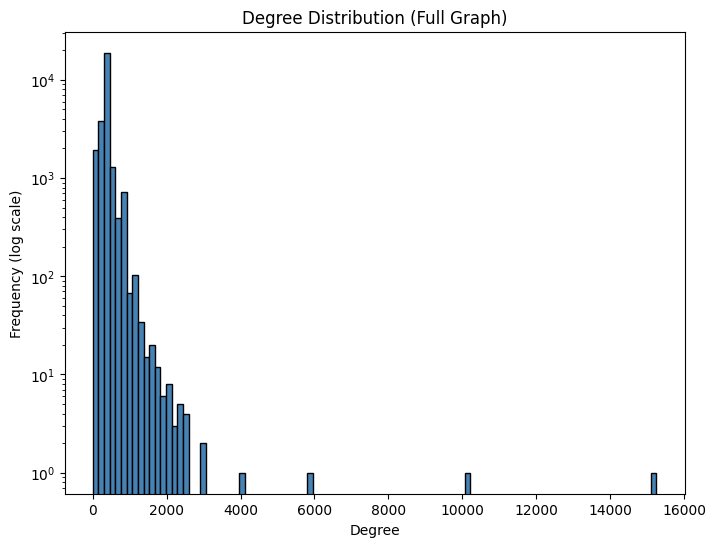


Top 10 nodes by Degree Centrality (Full Graph):
  dependabot[bot]: 0.5586
  eltociear: 0.3728
  github-actions[bot]: 0.2165
  jsoref: 0.1485
  spekulatius: 0.1097
  0xflotus: 0.1086
  dependabot-preview[bot]: 0.0940
  m1guelpf: 0.0932
  SimenB: 0.0922
  jamesgeorge007: 0.0918

Top 10 nodes by Approximate Betweenness Centrality (Full Graph):
  dependabot[bot]: 0.2630
  eltociear: 0.1602
  github-actions[bot]: 0.0422
  ReadmeCritic: 0.0155
  0xflotus: 0.0120
  jsoref: 0.0119
  spekulatius: 0.0115
  m1guelpf: 0.0111
  proppy: 0.0109
  cclauss: 0.0100

Top 10 nodes by Eigenvector Centrality (Full Graph):
  dependabot[bot]: 0.1530
  eltociear: 0.1186
  github-actions[bot]: 0.0699
  jamesgeorge007: 0.0569
  karlhorky: 0.0543
  styfle: 0.0535
  SimenB: 0.0522
  Andarist: 0.0516
  chentsulin: 0.0494
  arcanis: 0.0487

Top 10 nodes by PageRank (Full Graph):
  dependabot[bot]: 0.0013
  eltociear: 0.0009
  github-actions[bot]: 0.0005
  jsoref: 0.0003
  0xflotus: 0.0003
  ReadmeCritic: 0.0003
  y

In [3]:
##########################
# 2. BIPARTITE BUILDING  #
##########################
B = nx.Graph()

# Extract contributors & repos
contributors = list(df_clean.index)
repos = list(df_clean.columns)

# Add nodes to the bipartite graph
B.add_nodes_from(contributors, bipartite='contributors')
B.add_nodes_from(repos, bipartite='repos')

# Build edges only if there's at least 1 contribution.
EDGE_THRESHOLD = 1  # Only add edge if contributions >= 1
for contributor in contributors:
    for repo in repos:
        contrib_count = float(df_clean.at[contributor, repo])
        if contrib_count >= EDGE_THRESHOLD:
            B.add_edge(contributor, repo, weight=contrib_count)

print("Bipartite graph created:")
print(f"  #Contributor nodes: {len(contributors)}")
print(f"  #Repo nodes: {len(repos)}")
print(f"  #Edges in bipartite graph: {B.number_of_edges()}")

# Project bipartite -> contributor network
G = bipartite.weighted_projected_graph(B, contributors)
print("Contributor collaboration network:")
print(f"  Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

# Remove extra nodes from the contributor network
contributors_bipartite = set(contributors) # Get contributor nodes from bipartite graph
contributors_projected = set(G.nodes()) # Get nodes from the projected contributor network
extra_nodes = contributors_projected - contributors_bipartite # Find extra nodes in the projected network
print(f"Extra nodes in projected network: {len(extra_nodes)}")
print(f"Example extra nodes: {list(extra_nodes)[:10]}")
G.remove_nodes_from(extra_nodes) # remove extra nodes
print("Contributor collaboration network (extra nodes removed):")
print(f"  Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")


######################################################
# FUNDAMENTAL ANALYSIS (FULL GRAPH) BEFORE FILTERING #
######################################################
print("\n----- Fundamental Analysis on Full Graph -----")

# Basic network statistics
total_nodes = G.number_of_nodes()
total_edges = G.number_of_edges()
print(f"Total Nodes (Full Graph): {total_nodes}")
print(f"Total Edges (Full Graph): {total_edges}")

# Compute degree for every node
degrees = np.array([d for n, d in G.degree()])
print("\nDegree Statistics (Full Graph):")
print("  Min degree:", degrees.min())
print("  Max degree:", degrees.max())
print("  Mean degree:", degrees.mean())
print("  Median degree:", np.median(degrees))

# Plot the degree distribution (using log scale on y-axis)
plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=100, color='steelblue', edgecolor='black', log=True)
plt.title("Degree Distribution (Full Graph)")
plt.xlabel("Degree")
plt.ylabel("Frequency (log scale)")
plt.show()

# --- Centrality Measures on the Full Graph ---
# Degree Centrality
deg_cent_full = nx.degree_centrality(G)
top10_deg_full = sorted(deg_cent_full.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 nodes by Degree Centrality (Full Graph):")
for node, cent in top10_deg_full:
    print(f"  {node}: {cent:.4f}")

# Betweenness Centrality (approximate using k=100 for sampling)
try:
    betw_cent_full = nx.betweenness_centrality(G, k=100, normalized=True)
    top10_betw_full = sorted(betw_cent_full.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 nodes by Approximate Betweenness Centrality (Full Graph):")
    for node, cent in top10_betw_full:
        print(f"  {node}: {cent:.4f}")
except Exception as e:
    print("Betweenness Centrality computation failed:", e)

# Eigenvector Centrality
try:
    eig_cent_full = nx.eigenvector_centrality(G, max_iter=1000)
    top10_eig_full = sorted(eig_cent_full.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 nodes by Eigenvector Centrality (Full Graph):")
    for node, cent in top10_eig_full:
        print(f"  {node}: {cent:.4f}")
except Exception as e:
    print("Eigenvector Centrality computation failed:", e)

# PageRank
try:
    pagerank_full = nx.pagerank(G)
    top10_pr_full = sorted(pagerank_full.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 nodes by PageRank (Full Graph):")
    for node, pr in top10_pr_full:
        print(f"  {node}: {pr:.4f}")
except Exception as e:
    print("PageRank computation failed:", e)

Average Degree (⟨k⟩): 395.88465061741965


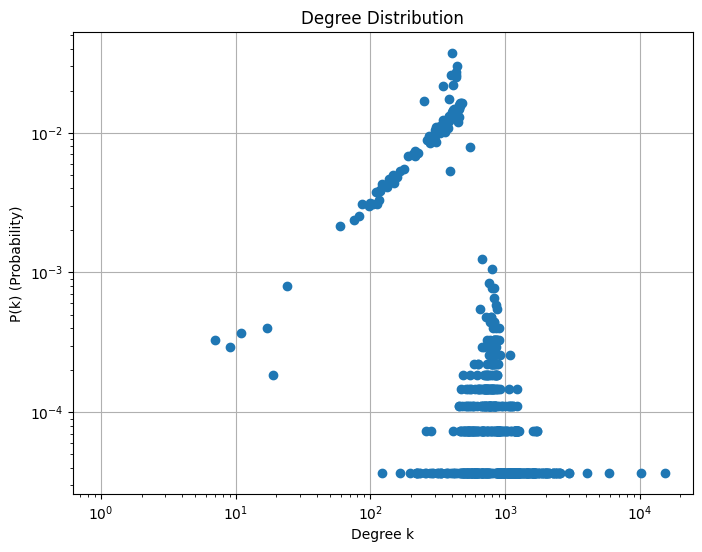

In [21]:
##################################################
# 2.5 More Structural Analysis for Full Network  #
##################################################
# ------------------------
# 1. Average Degree ⟨k⟩
# ------------------------
average_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print(f"Average Degree (⟨k⟩): {average_degree}")

# ------------------------
# 2. Degree Distribution P(k)
# ------------------------
degree_sequence = [d for n, d in G.degree()]
degree_counts = np.bincount(degree_sequence)
degree_probabilities = degree_counts / sum(degree_counts)

# Plot Degree Distribution
plt.figure(figsize=(8, 6))
plt.loglog(range(len(degree_probabilities)), degree_probabilities, marker="o", linestyle="None")
plt.xlabel("Degree k")
plt.ylabel("P(k) (Probability)")
plt.title("Degree Distribution")
plt.grid()
plt.show()

In [4]:
############################
# 3. OPTIONAL SUBGRAPHING  #
############################
# For visualization and advanced computations, we now filter the full graph.
# Here, we keep nodes with degree >= a threshold (DEGREE_FILTER).
DEGREE_FILTER = 463
filtered_nodes = [n for n, deg in G.degree() if deg >= DEGREE_FILTER]
G_filtered = G.subgraph(filtered_nodes).copy()
print(f"\nFiltered subgraph with degree >= {DEGREE_FILTER}:")
print(f"  Nodes: {G_filtered.number_of_nodes()}, Edges: {G_filtered.number_of_edges()}")


Filtered subgraph with degree >= 463:
  Nodes: 3104, Edges: 474540


In [5]:
##################################
# 4. CENTRALITY & COMMUNITY (FILTERED)
##################################
# Compute centrality measures on the filtered subgraph.
deg_centrality_filt = nx.degree_centrality(G_filtered)
closeness_centrality_filt = nx.closeness_centrality(G_filtered)
eigenvector_centrality_filt = nx.eigenvector_centrality(G_filtered, max_iter=1000)
pagerank_filt = nx.pagerank(G_filtered)

# Store them as attributes in the filtered graph
for node in G_filtered.nodes():
    G_filtered.nodes[node]['deg_cent'] = deg_centrality_filt[node]
    G_filtered.nodes[node]['clos_cent'] = closeness_centrality_filt[node]
    G_filtered.nodes[node]['eig_cent'] = eigenvector_centrality_filt[node]
    G_filtered.nodes[node]['pagerank'] = pagerank_filt[node]

top10_deg_filt = sorted(deg_centrality_filt.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 nodes by Degree Centrality (Filtered):")
for nd, sc in top10_deg_filt:
    print(f"  {nd}: {sc:.4f}")

try:
    betw_centrality_filt = nx.betweenness_centrality(G_filtered, k=100, normalized=True)
    top10_betw_filt = sorted(betw_centrality_filt.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 nodes by Approximate Betweenness Centrality (Filtered):")
    for nd, sc in top10_betw_filt:
        print(f"  {nd}: {sc:.4f}")
except Exception as e:
    print("Betweenness Centrality (Filtered) computation failed:", e)

try:
    top10_eig_filt = sorted(eigenvector_centrality_filt.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 nodes by Eigenvector Centrality (Filtered):")
    for nd, sc in top10_eig_filt:
        print(f"  {nd}: {sc:.4f}")
except Exception as e:
    print("Eigenvector Centrality (Filtered) computation failed:", e)

top10_pr_filt = sorted(pagerank_filt.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 nodes by PageRank (Filtered):")
for nd, pr in top10_pr_filt:
    print(f"  {nd}: {pr:.4f}")


Top 10 nodes by Degree Centrality (Filtered):
  dependabot[bot]: 0.5798
  github-actions[bot]: 0.5659
  eltociear: 0.5027
  bharatr21: 0.3261
  charliermarsh: 0.3029
  alexiri: 0.3029
  untilhamza: 0.3029
  salmantec: 0.3007
  0xflotus: 0.2469
  kant: 0.2063

Top 10 nodes by Approximate Betweenness Centrality (Filtered):
  github-actions[bot]: 0.1740
  eltociear: 0.1246
  dependabot[bot]: 0.1154
  kant: 0.0252
  salmantec: 0.0243
  bharatr21: 0.0188
  suravshrestha: 0.0144
  lex111: 0.0128
  charliermarsh: 0.0120
  alexiri: 0.0120

Top 10 nodes by Eigenvector Centrality (Filtered):
  bharatr21: 0.0545
  charliermarsh: 0.0544
  alexiri: 0.0544
  untilhamza: 0.0544
  eltociear: 0.0453
  ttsugriy: 0.0445
  mgoin: 0.0443
  Bearnardd: 0.0443
  parambharat: 0.0443
  harupy: 0.0443

Top 10 nodes by PageRank (Filtered):
  dependabot[bot]: 0.0040
  eltociear: 0.0029
  github-actions[bot]: 0.0019
  jsoref: 0.0012
  SimenB: 0.0010
  styfle: 0.0010
  Andarist: 0.0009
  jamesgeorge007: 0.0009
  0x

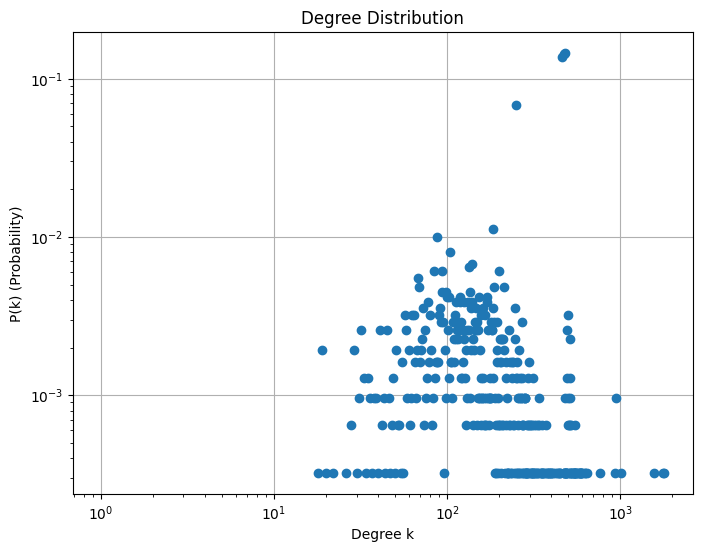

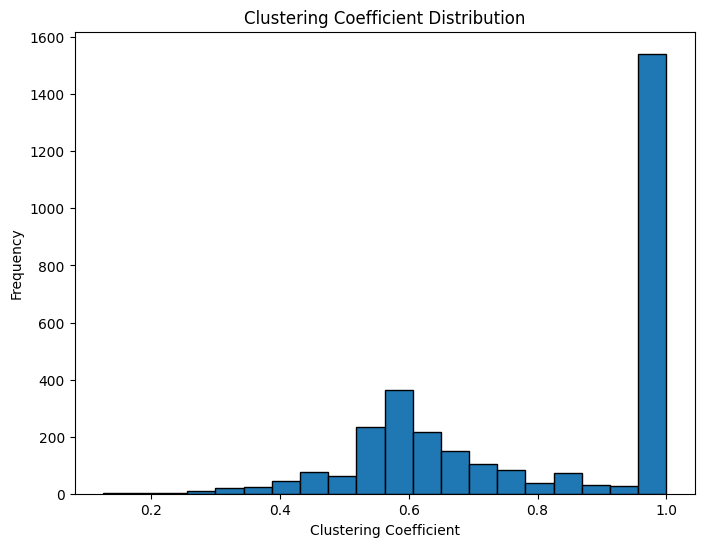

{'Characteristic Path Length (L_t)': 2.0657594413121987,
 'Average Degree (⟨k⟩)': 305.7603092783505,
 'Average Path Length (⟨l⟩)': 2.0657594413121987,
 'Global Clustering Coefficient (⟨C⟩)': 0.8051718238229967}

In [19]:
# ------------------------
# 1. Characteristic Path Length (L(t))
# ------------------------
if nx.is_connected(G_filtered):
    L_t = nx.average_shortest_path_length(G_filtered)
else:
    # Compute for the largest connected component
    largest_cc = max(nx.connected_components(G_filtered), key=len)
    L_t = nx.average_shortest_path_length(G.subgraph(largest_cc))

# ------------------------
# 2. Average Degree ⟨k⟩
# ------------------------
average_degree = sum(dict(G_filtered.degree()).values()) / G_filtered.number_of_nodes()

# ------------------------
# 3. Degree Distribution P(k)
# ------------------------
degree_sequence = [d for n, d in G_filtered.degree()]
degree_counts = np.bincount(degree_sequence)
degree_probabilities = degree_counts / sum(degree_counts)

# Plot Degree Distribution
plt.figure(figsize=(8, 6))
plt.loglog(range(len(degree_probabilities)), degree_probabilities, marker="o", linestyle="None")
plt.xlabel("Degree k")
plt.ylabel("P(k) (Probability)")
plt.title("Degree Distribution")
plt.grid()
plt.show()

# ------------------------
# 4. Average Path Length ⟨l⟩ (Across Components)
# ------------------------
if nx.is_connected(G_filtered):
    avg_path_length = nx.average_shortest_path_length(G_filtered)
else:
    avg_path_lengths = [nx.average_shortest_path_length(G_filtered.subgraph(c)) for c in nx.connected_components(G_filtered) if len(c) > 1]
    avg_path_length = np.mean(avg_path_lengths) if avg_path_lengths else float('inf')

# ------------------------
# 5. Clustering Coefficient C_i
# ------------------------
clustering_coeffs = nx.clustering(G_filtered)  # Clustering per node
global_clustering = nx.average_clustering(G_filtered)  # Overall clustering coefficient

# Plot Clustering Coefficient Distribution
plt.figure(figsize=(8, 6))
plt.hist(clustering_coeffs.values(), bins=20, edgecolor='black')
plt.xlabel("Clustering Coefficient")
plt.ylabel("Frequency")
plt.title("Clustering Coefficient Distribution")
plt.show()

# Display results
results_filtered = {
    "Characteristic Path Length (L_t)": L_t,
    "Average Degree (⟨k⟩)": average_degree,
    "Average Path Length (⟨l⟩)": avg_path_length,
    "Global Clustering Coefficient (⟨C⟩)": global_clustering
}

results_filtered

In [6]:
##############################
# 5. COMMUNITY DETECTION (FILTERED)
##############################
import community.community_louvain as community_louvain

partition_filt = community_louvain.best_partition(G_filtered)
for node, comm in partition_filt.items():
    G_filtered.nodes[node]['community'] = comm

num_coms_filt = len(set(partition_filt.values()))
print(f"\nDetected {num_coms_filt} communities in the filtered subgraph.")


Detected 5 communities in the filtered subgraph.


In [7]:
###########################################
# 6. ROBUSTNESS SIMULATION (FILTERED ONLY)
###########################################
def largest_component_size(graph):
    if graph.number_of_nodes() == 0:
        return 0
    return len(max(nx.connected_components(graph), key=len))

G_targeted = copy.deepcopy(G_filtered)
G_random = copy.deepcopy(G_filtered)

targeted_nodes = sorted(G_targeted.degree(), key=lambda x: x[1], reverse=True)
component_sizes_targeted = []

print("\nStarting targeted removal simulation (Filtered Subgraph):")
for i, (node, _) in enumerate(targeted_nodes):
    G_targeted.remove_node(node)
    if (i + 1) % 50 == 0:
        size = largest_component_size(G_targeted)
        component_sizes_targeted.append(size)
        print(f"  Removed {i+1} nodes, largest component size: {size}")

nodes_random = list(G_random.nodes())
random.shuffle(nodes_random)
component_sizes_random = []

print("\nStarting random removal simulation (Filtered Subgraph):")
for i, node in enumerate(nodes_random):
    G_random.remove_node(node)
    if (i + 1) % 50 == 0:
        size = largest_component_size(G_random)
        component_sizes_random.append(size)
        print(f"  Removed {i+1} nodes, largest component size: {size}")


Starting targeted removal simulation (Filtered Subgraph):
  Removed 50 nodes, largest component size: 3054
  Removed 100 nodes, largest component size: 2565
  Removed 150 nodes, largest component size: 2565
  Removed 200 nodes, largest component size: 2565
  Removed 250 nodes, largest component size: 2565
  Removed 300 nodes, largest component size: 2565
  Removed 350 nodes, largest component size: 2565
  Removed 400 nodes, largest component size: 2565
  Removed 450 nodes, largest component size: 2565
  Removed 500 nodes, largest component size: 2564
  Removed 550 nodes, largest component size: 1686
  Removed 600 nodes, largest component size: 1686
  Removed 650 nodes, largest component size: 1686
  Removed 700 nodes, largest component size: 1686
  Removed 750 nodes, largest component size: 1686
  Removed 800 nodes, largest component size: 1686
  Removed 850 nodes, largest component size: 1686
  Removed 900 nodes, largest component size: 1686
  Removed 950 nodes, largest component siz

In [8]:
######################################
# 7. EXPORT FOR VISUALIZATION
######################################
# (Optional) Export the filtered subgraph to Gephi for further exploration.
# nx.write_gexf(G_filtered, "github_collaboration_filtered.gexf")
# print("Filtered subgraph exported to github_collaboration_filtered.gexf")

############################
# END OF NOTEBOOK
############################

# Summary of Optimizations:
# - Data is loaded and cleaned from a CSV, with duplicate contributors aggregated.
# - A bipartite graph is built (contributors vs. repos) and then projected to create the full contributor network.
# - Fundamental analysis is performed on the full graph (basic stats, degree distribution,
#   and centrality measures including Degree, Betweenness, Eigenvector, and PageRank), providing an overall view before filtering.
# - The graph is then filtered by a degree threshold (DEGREE_FILTER) for manageability.
# - Centrality and community detection are computed on the filtered subgraph.
# - Robustness simulations are run on the filtered subgraph to assess network resilience.
#
# Adjust thresholds as needed to balance capturing network structure with performance constraints.

Degree Statistics:
  Min: 7
  Max: 15245
  Mean: 395.88465061741965
  Median: 401.0


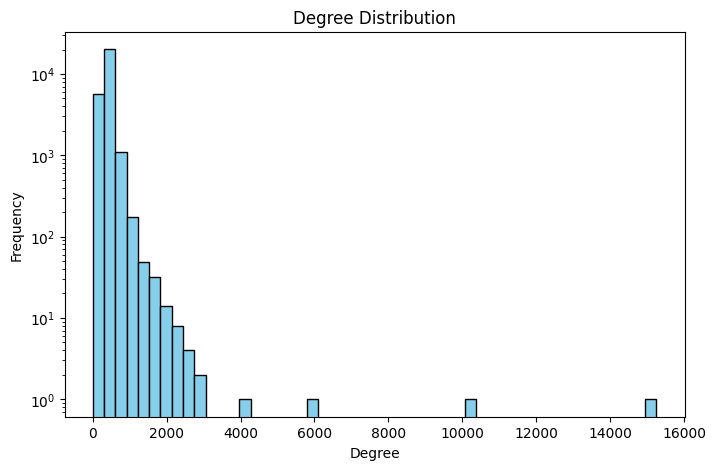

90th percentile degree threshold: 463.0
Using top 10% of nodes: degree >= 463
Filtered subgraph with degree >= 90th percentile:
  Nodes: 3104
  Edges: 474540


In [9]:
### FILTER CALCULATION

import numpy as np
import matplotlib.pyplot as plt

# Compute degrees for all nodes in the full graph
degrees = np.array([d for n, d in G.degree()])

# Print basic statistics
print("Degree Statistics:")
print("  Min:", degrees.min())
print("  Max:", degrees.max())
print("  Mean:", degrees.mean())
print("  Median:", np.median(degrees))

# Plot the degree distribution histogram
plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=50, color="skyblue", edgecolor="black")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale("log")  # log scale helps reveal the tail behavior
plt.show()

# Determine a new threshold based on a percentile (e.g., 90th percentile)
threshold = np.percentile(degrees, 90)
print("90th percentile degree threshold:", threshold)

# Alternatively, if you want a fixed number of nodes (e.g., top 10%):
top_10_percent_threshold = np.percentile(degrees, 90)  # Top 10% will be above the 90th percentile
print("Using top 10% of nodes: degree >= {:.0f}".format(top_10_percent_threshold))

# Create a filtered subgraph using this new threshold:
filtered_nodes_new = [n for n, d in G.degree() if d >= top_10_percent_threshold]
G_filtered_new = G.subgraph(filtered_nodes_new).copy()
print("Filtered subgraph with degree >= 90th percentile:")
print("  Nodes:", G_filtered_new.number_of_nodes())
print("  Edges:", G_filtered_new.number_of_edges())